### [01] diabetes.csv 데이터세트를 이용해 다음사항을 수행하여 당뇨병 여부를 판단하는 머신러닝 예측 모델을 작성하고 평가하세요.
- zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']는 0값을 평균값으로 대체
- 정확도, 정밀도, 재현율, F1 Score, ROC_AUC Score를 포함하는 평가지표 사용자 함수 작성
- 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화
- 전체적인 성능 평가 지표를 유지하면서 재현율을 약간 향상시키는 임계값 산출<br/>
  (재현율을 높이기 위해서는 임계값을 낮춰야 함.)
- 산출된 임계값을 적용한 평가

※ 피처 정보  
'Pregnancies'(임신 횟수), 'Glucose'(포도당 부하 검사 수치), 'BloodPressure'(혈압),
'SkinThickness'(팔 삼두근 뒤쪽의 피하지방 측정값, 'Insulin'(혈청 인슈린),
'BMI'(체질량 지수), 'DiabetesPedigreeFunction'(당뇨 내력 가중치 값), 'Age', 'Outcome'

In [2]:
# Python의 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# # 코드 실행시 경고창 실행 여부 관련
# import warnings
# warnings.filterwarnings('ignore')


# # Google Drive Mount 하기
from google.colab import drive
drive.mount('/content/drive')


# 사이킷런 관련 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

Mounted at /content/drive


In [5]:
data_df = pd.read_csv('/content/drive/MyDrive/hjh_kita_directory/Github/kita_231026/m5_ml/diabetes.csv')
print('[ Data의 Outcome의 Value에 따른 갯수 확인 ] \n', data_df['Outcome'].value_counts(), '\n')

data_df.head(10)

[ Data의 Outcome의 Value에 따른 갯수 확인 ] 
 0    500
1    268
Name: Outcome, dtype: int64 



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [ ]:
# 사용자 함수 생성(평가 지표 함수 ::: 오차행렬과 정확도, 정밀도, 재현율, f1 Score, roc_auc)
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test=None, pred=None, pred_proba=None):
  confusion = confusion_matrix(y_test, pred)
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)

  print("오차 행렬 : \n", confusion, '\n')
  print('정확도: {0:.4f} / 정밀도: {1:.4f} / 재현율: {2:.4f} / f1 score: {3:.4f} / AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
  print('=' * 100, '\n')

In [ ]:
# 사용자 함수 생성 (정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화)
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # x축을 threshold 값으로, y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
  plt.figure(figsize=(8,5))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold값 X축의 Scale을 0.1 eksdnlfh qusrud
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # x축, y축 label과 legend, grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()

In [ ]:
# 예측 모델 생성
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 컬럼으로 레이블 값임. (컬럼 위치 -1을 이용해 추출)
X = data_df.iloc[:, :-1]
y = data_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)
# stratify는 훈련/테스트 데이터들이 원래의 input dataset의 클래스의 비율과 같은 비율을 가지도록 할 것인지 지정한다.
# 예를 들어 0,1의 클래스가 input dataset에 20:80 비율로 있었다면 훌련 데이터와 테스트 데이터 역시 각각의 클래스가 같은 비율로 있도록 지정

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 사용자 함수(get_clf_eval(), 평가 지표 함수) 실행
get_clf_eval(y_test, pred, pred_proba)

오차 행렬 : 
 [[88 12]
 [23 31]] 

정확도: 0.7727 / 정밀도: 0.7209 / 재현율: 0.5741 / f1 score: 0.6392 / AUC: 0.7919


In [ ]:
data_df.describe()        # 통계 정보 확인

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
data_df[data_df.Glucose == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


<Axes: xlabel='Glucose', ylabel='Count'>

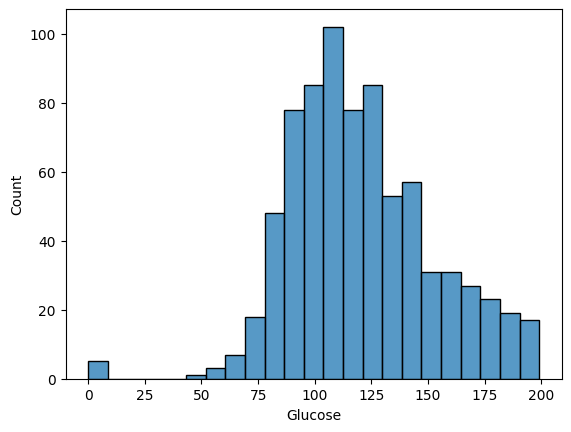

In [ ]:
import seaborn as sns

sns.histplot(data_df.Glucose)

In [ ]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']     # Pregnancies는 '출산횟수'를 의미하므로 0값 인정

# 전체 데이터 건수 (데이터 건수는 항목별로 다르지 않기 때문에 대표 필드 한개로 계산해도 됨.)
total_count = data_df['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출 후, 퍼센트 계산
for feature in zero_features:
  zero_count = data_df[data_df[feature] == 0][feature].count()
  print("{0} 내 value가 '0'인 건수는 {1} 건, 전체에서 차지하는 비율은 {2:.2f} %".format(feature, zero_count, 100*zero_count/total_count))

Glucose 내 value가 '0'인 건수는 5 건, 전체에서 차지하는 비율은 0.65 %
BloodPressure 내 value가 '0'인 건수는 35 건, 전체에서 차지하는 비율은 4.56 %
SkinThickness 내 value가 '0'인 건수는 227 건, 전체에서 차지하는 비율은 29.56 %
Insulin 내 value가 '0'인 건수는 374 건, 전체에서 차지하는 비율은 48.70 %
BMI 내 value가 '0'인 건수는 11 건, 전체에서 차지하는 비율은 1.43 %


In [ ]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
for feature in zero_features:
  data_df[feature].replace(0, data_df[feature].mean(),inplace=True)
# data_df[zero_features] = data_df[zero_features].replace(0, data_df[zero_features].mean())       # for문을 사용하지 않고 0값을 대체할 수 있는 간단 코드 (강사님 코드)

data_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# 로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 하는 것이 좋으며
# 다시 학습/테스트 데이터 세트로 나누고 로지스틱 회귀를 적용, 성능 평가 지표를 확인

X = data_df.iloc[:, :-1]
y = data_df.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

# 사용자 함수(get_clf_eval(), 평가 지표 함수) 다시 실행
get_clf_eval(y_test, pred, pred_proba)

오차 행렬 : 
 [[90 10]
 [21 33]] 

정확도: 0.7987 / 정밀도: 0.7674 / 재현율: 0.6111 / f1 score: 0.6804 / AUC: 0.8433


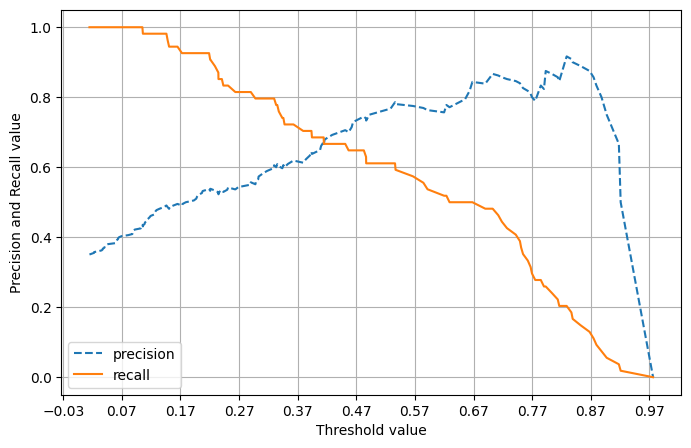

In [ ]:
# 사용자 함수(정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태로 시각화)
precision_recall_curve_plot(y_test, pred_proba)

In [ ]:
from sklearn.preprocessing import Binarizer
pred_proba_c1 = pred_proba.reshape(-1, 1)

# 사용자 함수 생성 (임계값에 따른 평가 수치 출력 함수)
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
  # thresholds 리스트 객체 내의 값을 차례로 iteration하면서 Evaluation 수행
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:', custom_threshold)

    get_clf_eval(y_test, custom_predict, pred_proba_c1)

In [ ]:
# 임곗값을 0.3에서 0.5까지 변화시키면서 평가 지표 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
get_eval_by_threshold(y_test, pred_proba_c1, thresholds)

임곗값: 0.3
오차 행렬 : 
 [[67 33]
 [11 43]] 

정확도: 0.7143 / 정밀도: 0.5658 / 재현율: 0.7963 / f1 score: 0.6615 / AUC: 0.8433

임곗값: 0.33
오차 행렬 : 
 [[72 28]
 [12 42]] 

정확도: 0.7403 / 정밀도: 0.6000 / 재현율: 0.7778 / f1 score: 0.6774 / AUC: 0.8433

임곗값: 0.36
오차 행렬 : 
 [[76 24]
 [15 39]] 

정확도: 0.7468 / 정밀도: 0.6190 / 재현율: 0.7222 / f1 score: 0.6667 / AUC: 0.8433

임곗값: 0.39
오차 행렬 : 
 [[78 22]
 [16 38]] 

정확도: 0.7532 / 정밀도: 0.6333 / 재현율: 0.7037 / f1 score: 0.6667 / AUC: 0.8433

임곗값: 0.42
오차 행렬 : 
 [[84 16]
 [18 36]] 

정확도: 0.7792 / 정밀도: 0.6923 / 재현율: 0.6667 / f1 score: 0.6792 / AUC: 0.8433

임곗값: 0.45
오차 행렬 : 
 [[85 15]
 [18 36]] 

정확도: 0.7857 / 정밀도: 0.7059 / 재현율: 0.6667 / f1 score: 0.6857 / AUC: 0.8433

임곗값: 0.48
오차 행렬 : 
 [[88 12]
 [19 35]] 

정확도: 0.7987 / 정밀도: 0.7447 / 재현율: 0.6481 / f1 score: 0.6931 / AUC: 0.8433

임곗값: 0.5
오차 행렬 : 
 [[90 10]
 [21 33]] 

정확도: 0.7987 / 정밀도: 0.7674 / 재현율: 0.6111 / f1 score: 0.6804 / AUC: 0.8433



In [ ]:
# 재현율을 약간 올리면서 전체적인 성능 평가 지표를 올리는 임곗값을 '0.48'로 확인할 수 있음.